In [2]:
import torch
import torchvision
import timm
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

model_names = timm.list_models('*vit*tiny*')
# pprint(model_names)

/Users/zyxu/opt/anaconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = timm.create_model("vit_tiny_patch16_384", img_size=224,pretrained=False)
state_dict = model.state_dict()
num_heads = 3
model.blocks


Sequential(
  (0): Block(
    (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
    (attn): Attention(
      (qkv): Linear(in_features=192, out_features=576, bias=True)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=192, out_features=192, bias=True)
      (proj_drop): Dropout(p=0.0, inplace=False)
    )
    (ls1): Identity()
    (drop_path1): Identity()
    (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
    (mlp): Mlp(
      (fc1): Linear(in_features=192, out_features=768, bias=True)
      (act): GELU(approximate='none')
      (drop1): Dropout(p=0.0, inplace=False)
      (fc2): Linear(in_features=768, out_features=192, bias=True)
      (drop2): Dropout(p=0.0, inplace=False)
    )
    (ls2): Identity()
    (drop_path2): Identity()
  )
  (1): Block(
    (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
    (attn): Attention(
      (qkv): Linear(in_features=192, out_features=576, bias=True)
      (attn_drop): Dro

In [8]:
# state_dict = model.state_dict()
# state_dict

In [4]:
# Now run your model with some data
input_tensor = torch.rand(64, 3, 224, 224)

In [5]:
# Assuming `model` is your loaded ViT model
patch_embeddings = model.patch_embed.proj(input_tensor)  # For some input_tensor of shape [batch_size, 3, H, W]
patch_embeddings.shape

torch.Size([64, 192, 14, 14])

In [6]:
# Extracting positional embeddings
positional_embeddings = model.state_dict()['pos_embed']
positional_embeddings.shape

torch.Size([1, 197, 192])

### intermediate outputs

In [9]:
# List to save outputs
intermediate_outputs = []

# Hook function
def pre_forward_hook(module, input):
    intermediate_outputs.append(input[0].clone())

# Register the pre-forward hook with attention layers in all blocks
for block in model.blocks:
    block.attn.register_forward_pre_hook(pre_forward_hook)



In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
statistics = {'mean': [0.4914, 0.4822, 0.4465], 
            'std':  [0.247, 0.243, 0.261]}
img_size = 224
root = '/Users/zyxu/Documents/py/datasets'
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, 
                                        transform=transforms.Compose([
                                            transforms.Resize((img_size, img_size)),
                                            transforms.ToTensor(),
                                            transforms.Normalize(**statistics)
                                        ]))
# Compute the mean and standard deviation of the dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False)
iterator = iter(trainloader)
data = next(iterator)

Files already downloaded and verified


In [11]:
intermediate_outputs = []
out = model(data[0])

In [14]:
for i, val in enumerate(intermediate_outputs):
    print(val.shape)

torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])
torch.Size([64, 197, 192])


In [19]:
h = intermediate_outputs[0]
mu = h.mean(0).mean(0)
mu.shape

torch.Size([192])

In [20]:
h.mean(0).shape

torch.Size([197, 192])

In [22]:
pos = h.mean(0) - mu
pos.shape

torch.Size([197, 192])

In [24]:
ctx = h.mean(1) - mu
ctx.shape

torch.Size([64, 192])

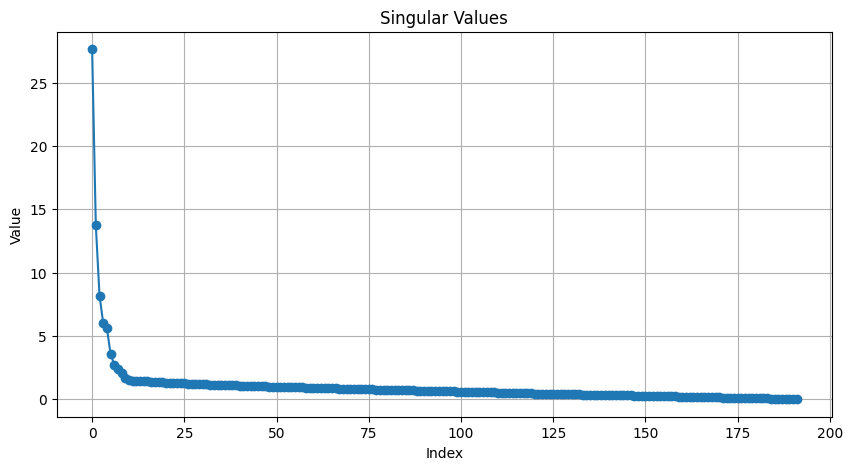

In [28]:
# Perform SVD
U, S, V = torch.svd(pos)

# Let's say we want to retain only the top k singular values for a rank-k approximation
k = 10
U_k = U[:, :k]
S_k = torch.diag(S[:k])
V_k = V[:, :k]

# Reconstruct the matrix using only the top k singular values
pos_approx = U_k @ S_k @ V_k.T

# Plot singular values
plt.figure(figsize=(10, 5))
plt.plot(S.detach().numpy(), 'o-')
plt.title('Singular Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()